## Comparison empirical and simulated data

requirements: 
- empirical time series (mean + single trials)
- simulated time series traces (mean + all layers) for the two hypothesis
- CSD with varying dipole strength

In [2]:
import os
import shutil
import numpy as np
import nibabel as nib
import k3d
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt
import tempfile

from lameg.simulate import run_current_density_simulation
from lameg.laminar import compute_csd
from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.viz import plot_csd
import spm_standalone

In [3]:
subj_id='sub-001'
ses_id = 'ses-01'
epoch='motor'
c_idx=3
subj_dir=os.path.join('/home/common/bonaiuto/cued_action_meg/derivatives/processed',subj_id)
subj_dir_sss=os.path.join('/home/common/bonaiuto/cued_action_meg/derivatives/processed_sss',subj_id)
subj_surf_dir=os.path.join(subj_dir,'surf')
multilayer_mesh_fname = os.path.join(subj_surf_dir, 'multilayer.11.ds.link_vector.fixed.gii')
pial_mesh_fname = os.path.join(subj_surf_dir,'pial.ds.link_vector.fixed.gii')

# External dependencies of the doc
mri_fname = os.path.join(subj_dir, 't1w.nii')
smooth_file = os.path.join(subj_surf_dir, 'FWHM5.00_multilayer.11.ds.link_vector.fixed.mat')
base_fname = os.path.join(subj_dir_sss, ses_id, f'spm/pmcspm_converted_autoreject-{subj_id}-{ses_id}-{epoch}-epo.mat')
base_fname_t = os.path.join(subj_dir_sss, ses_id, f'spm/pcspm_converted_autoreject-{subj_id}-{ses_id}-{epoch}-epo.mat')
out_dir=os.path.join('./data', subj_id, ses_id, f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_motor_hnn')

fiducial_fname='/home/common/bonaiuto/cued_action_meg/raw/participants.tsv'
nas, lpa, rpa=get_fiducial_coords(subj_id, fiducial_fname)

In [4]:
spm = spm_standalone.initialize()

In [5]:
# Compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11

verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

sim_vertex = 5195

In [6]:
# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/sgailhard/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
30-May-2025 08:18:45 - Running job #1
------------------------------------------------------------------------
30-May-2025 08:18:46 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:18:56 - 30/05/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiom

## Simulate synthetic sensor level data
- define how to simulate (w/ dipole & orientations or with current density)
- retrieve the dipole needed
- simulate at different layers 
- reconstruct the source
- compute the CSD

In [7]:
# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR_levels = [-5,20]

# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

In [77]:
#specify the model version (if hypothesis one or two)
version = 2

In [ ]:
n_trials = 2

Text(0, 0.5, 'Amplitude (nAm)')

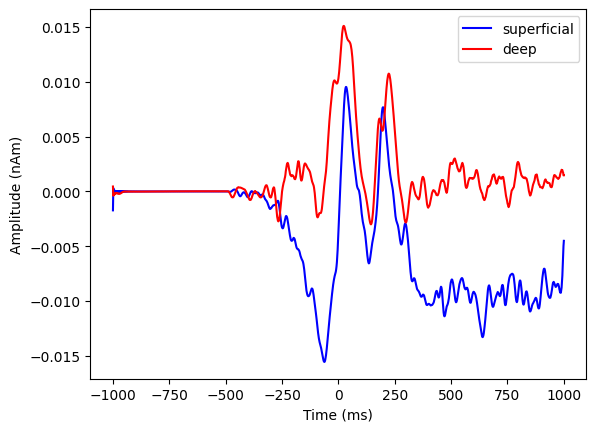

In [98]:
# Simulated signal
dipole_erf = np.loadtxt(os.path.join('./data',subj_id,ses_id,f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_hnn',f'dipole_merf_{n_trials}t.txt'))
dipole_erf = dipole_erf.T

exp_dpl = np.loadtxt(os.path.join('./data',subj_id,ses_id,f'{subj_id}_{ses_id}_c{c_idx}_{epoch}/hnn_input/',f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_erf.txt'))
exp_dpl.T

tot_signal = dipole_erf[1,:]
L2_signal = dipole_erf[2,:]
L5_signal = dipole_erf[3,:]
time = dipole_erf[0, :] 

new_time = np.linspace(-1000, 1000, 1201)

from scipy.signal import resample
sfreq_new = 600
sfreq_original = len(time) // (time[-1]/1000 - time[0]/1000)

n_samples_new = int(len(time) * sfreq_new / sfreq_original) + 1

tot_signal_d = resample(tot_signal, n_samples_new)
L2_signal_d = resample(L2_signal, n_samples_new)
L5_signal_d = resample(L5_signal, n_samples_new)

dipole_moment = [0.001, 0.001]

plt.plot(new_time,L2_signal_d*dipole_moment[0], 'b', label='superficial')
plt.plot(new_time,L5_signal_d*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (nAm)')
#plt.savefig(f'dipole_merf_50t_2_SNR{SNR}.svg')

Text(0, 0.5, 'Amplitude (nAm)')

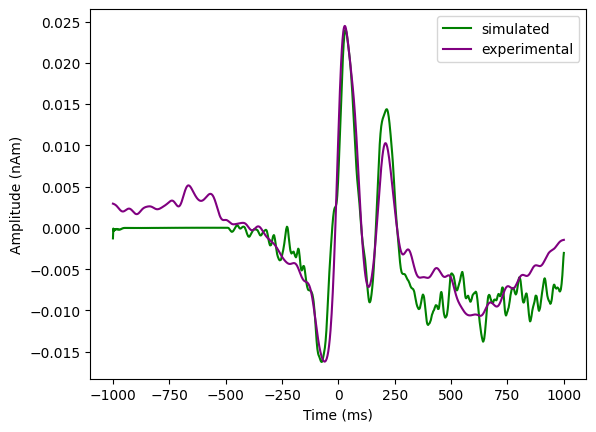

In [79]:
plt.plot(new_time,tot_signal_d*dipole_moment[1], 'g', label='simulated')
plt.plot(new_time,exp_dpl[:,1]*dipole_moment[1], color='purple', label='experimental')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (nAm)')
#plt.savefig('dipole_merf_50t_2_all.svg')

In [80]:
dipole_moments = [[1, 1],
                 [0.5, 1],
                 [0, 1],
                 [1, 0],
                 [1, 0.5]]

In [81]:
# bounds to normalize the plotting for every condition
vmin_vmax = None

In [82]:
# Simulate in every combination of signal
L2_range = [3]
L5_range = [7]

In [85]:
layer_csds = []
layer_kcsds = []
layer_derivs = []

Simulating in layer 3 and 7
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      11:46:11 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
Starting parallel pool (parpool) using the 'local' profile ...
Connected to the parallel pool (number of workers: 32).
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last it

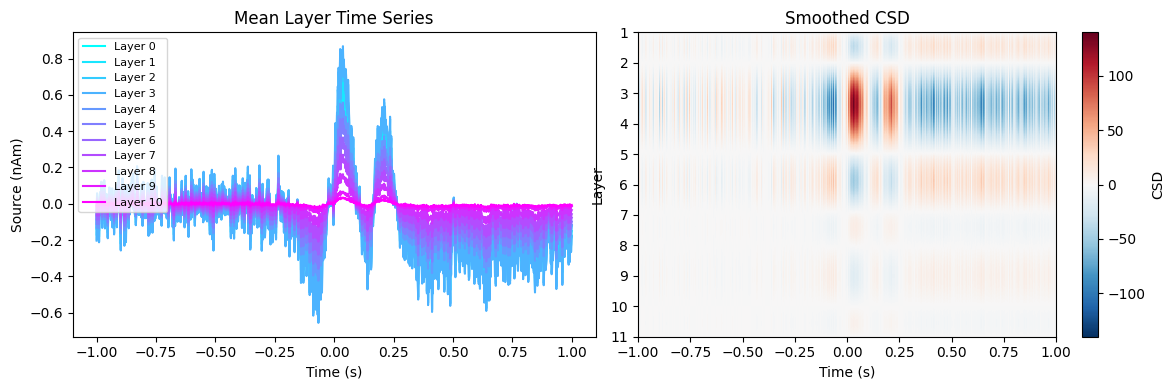

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      11:52:50 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  0.50 nAm , FWHM 5.00mm, mean moment density 32.96 pAm/mm2, peak momemnt density 72.14 pAm/mm2 

 In last iterati

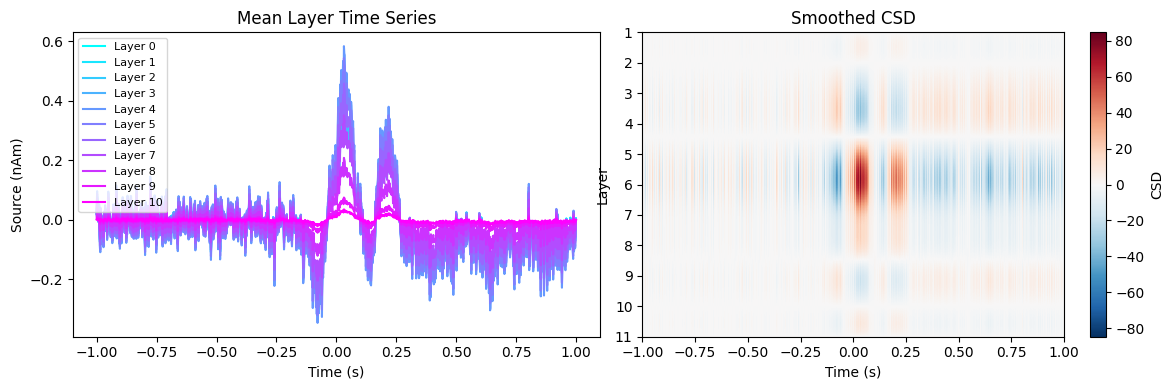

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      11:59:18 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.00 pAm/mm2, peak momemnt density 0.00 pAm/mm2 

 In last iteration

/home/sgailhard/miniconda3/envs/lameg/lib/python3.7/site-packages/quantities/quantity.py:337: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


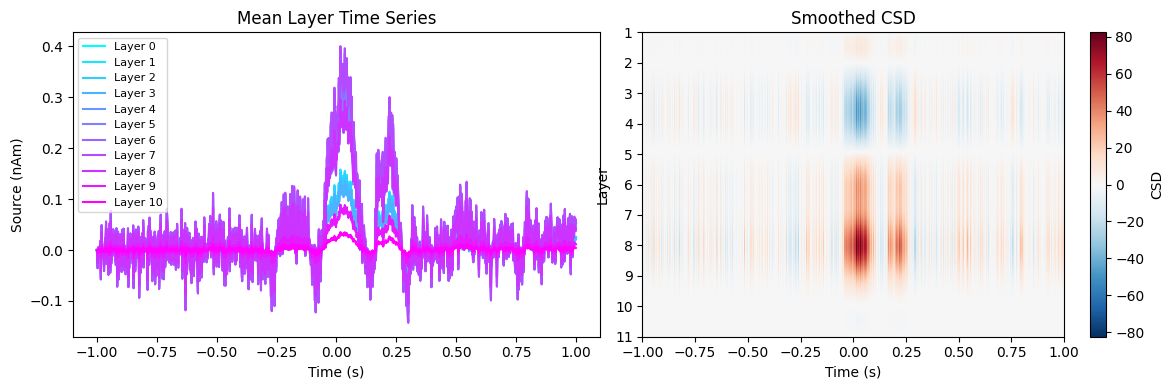

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:05:50 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  1.00 nAm , FWHM 5.00mm, mean moment density 65.91 pAm/mm2, peak momemnt density 144.29 pAm/mm2 

 In last iterat

/home/sgailhard/miniconda3/envs/lameg/lib/python3.7/site-packages/quantities/quantity.py:337: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


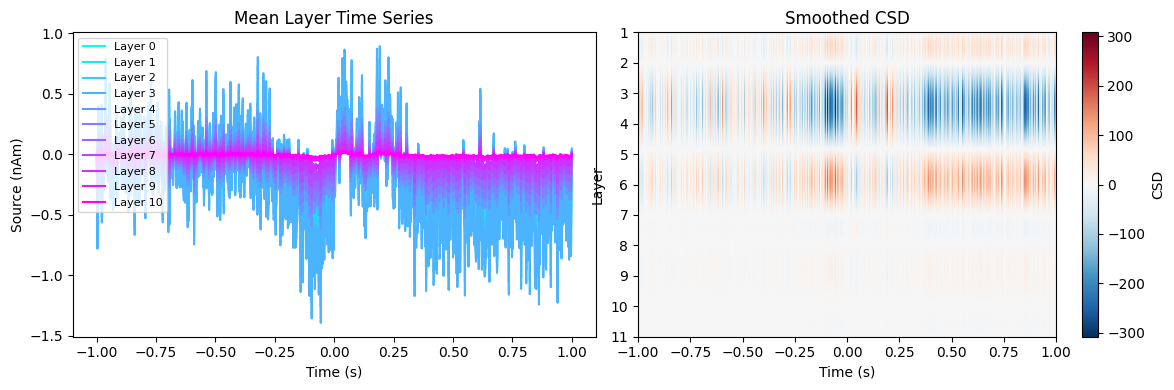

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:12:19 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  1.00 nAm , FWHM 5.00mm, mean moment density 65.91 pAm/mm2, peak momemnt density 144.29 pAm/mm2 

 In last iterat

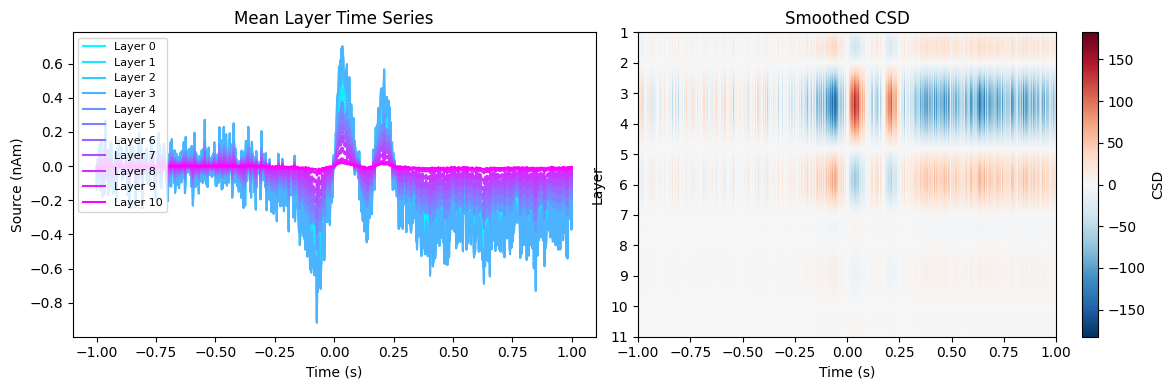

Simulating in layer 3 and 7
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:18:53 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  1.00 nAm , FWHM 5.00mm, mean moment density 65.91 pAm/mm2, peak momemnt density 144.

/home/sgailhard/miniconda3/envs/lameg/lib/python3.7/site-packages/quantities/quantity.py:337: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


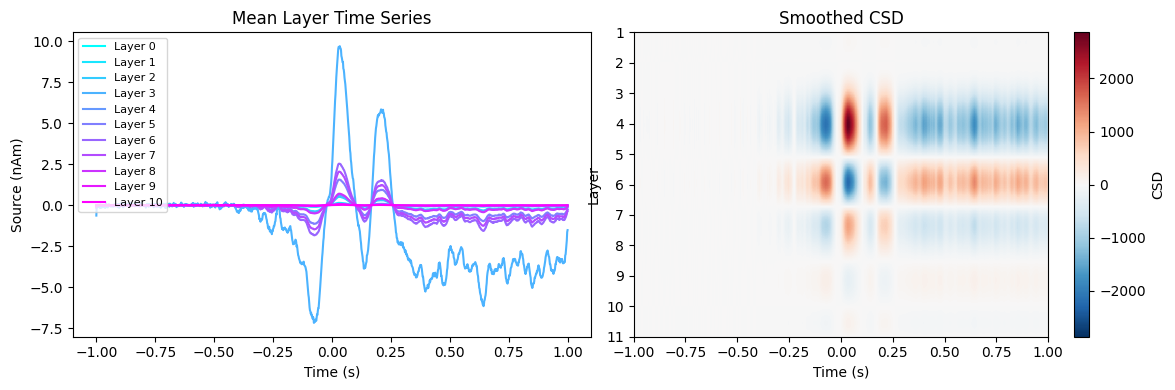

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:25:20 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  0.50 nAm , FWHM 5.00mm, mean moment density 32.96 pAm/mm2, peak momemnt density 72.14 pAm/mm2 

 In last iterati

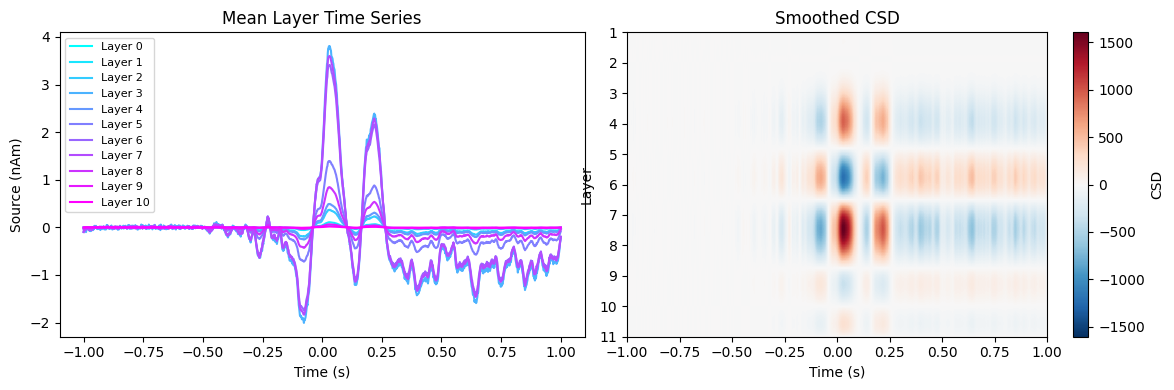

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:31:49 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  0.00 nAm , FWHM 5.00mm, mean moment density 0.00 pAm/mm2, peak momemnt density 0.00 pAm/mm2 

 In last iteration

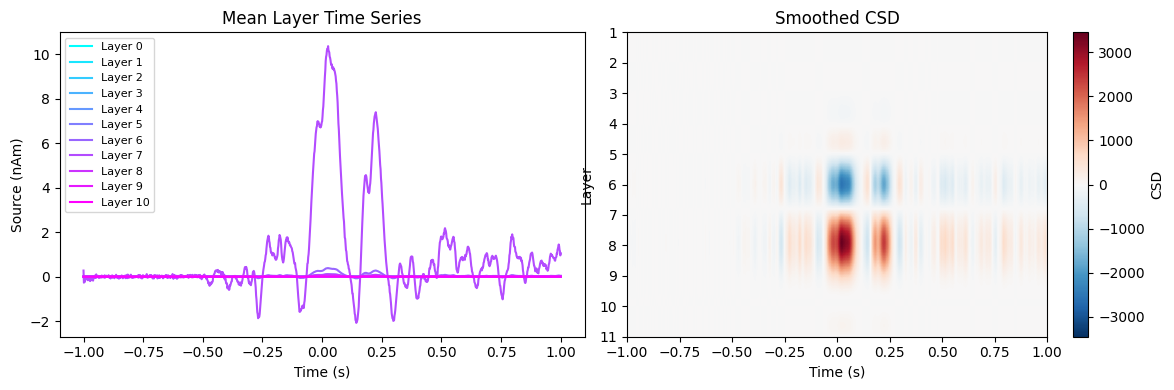

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:38:21 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  1.00 nAm , FWHM 5.00mm, mean moment density 65.91 pAm/mm2, peak momemnt density 144.29 pAm/mm2 

 In last iterat

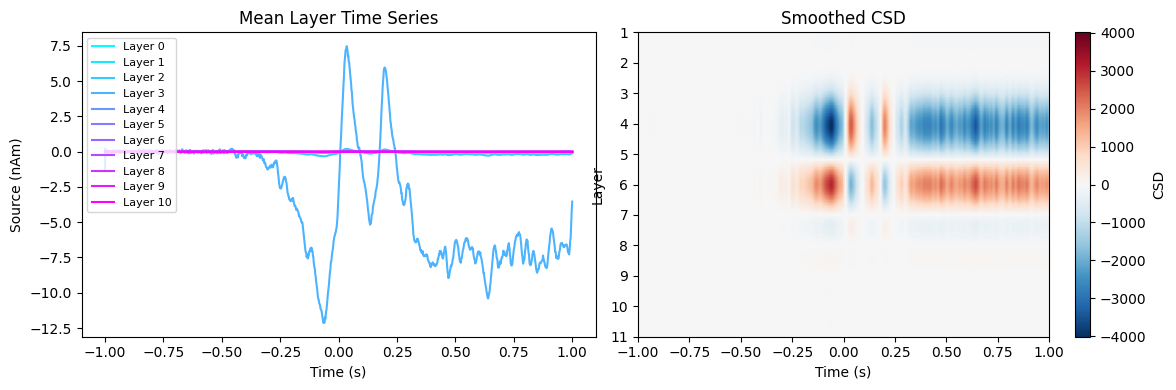

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+

        SPM: spm_eeg_lgainmat                      12:44:49 - 30/05/2025
        ----------------------------------------------------------------
computing surface normals
 - done
Saving prior in directory /home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/trials_source_time_series/simprior_sim_5195_merf_pmcspm_converted_autoreject-sub-001-ses-01-motor-epo
Using 1 iterations of 2 fixed patches

 In last iteration...setting up patch 1 with  1.00 nAm , FWHM 5.00mm, mean moment density 65.91 pAm/mm2, peak momemnt density 144.29 pAm/mm2 

 In last iterat

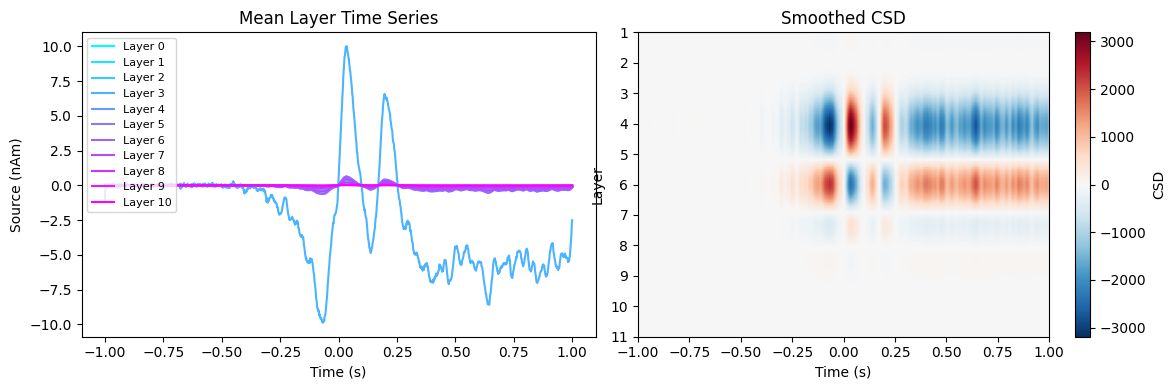

In [87]:
for SNR in SNR_levels: 
    for i in L2_range:
        L2_vertex = i*int(verts_per_surf)+sim_vertex
        for j in L5_range:
            L5_vertex = j*int(verts_per_surf)+sim_vertex

            print(f'Simulating in layer {i} and {j}')
            prefix = f'sim_{sim_vertex}_merf_'

            for h in range(len(dipole_moments)):
                plot_fname = f'sim_{sim_vertex}_v{version}_{i}_{j}_L2{dipole_moments[h][0]}L5{dipole_moments[h][1]}_SNR{SNR}.svg'

                l_sim_fname = run_current_density_simulation(
                    base_fname, 
                    prefix, 
                    [L2_vertex, L5_vertex], #l_vertexes
                    np.vstack([L2_signal_d, L5_signal_d]), 
                    dipole_moments[h], 
                    sim_patch_size, 
                    SNR, 
                    spm_instance=spm
                )  

                [_,_,MU] = invert_ebb(
                    multilayer_mesh_fname, 
                    l_sim_fname, 
                    n_layers, 
                    patch_size=patch_size, 
                    n_temp_modes=n_temp_modes, 
                    viz=False,
                    return_mu_matrix=True,
                    spm_instance=spm
                )

                # Layer peak
                peak = sim_vertex

                layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
                layer_coords = mesh.darrays[0].data[layer_verts,:]
                layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
                print(layer_dists)

                s_rate = 600

                # Get source time series for each layer
                layer_ts, time, _ = load_source_time_series(l_sim_fname, mu_matrix=MU, vertices=layer_verts)

                #mean_layer_ts = np.mean(layer_ts,axis=-1)
                mean_layer_ts = layer_ts
                [csd, smooth_csd] = compute_csd(mean_layer_ts,np.sum(layer_dists),600,smoothing='cubic')

                col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

                fig, ax = plt.subplots(1, 2, figsize=(12, 4))

                ax.flatten()

                for l in range(n_layers):
                    ax[0].plot(time, mean_layer_ts[l, :], label=f'Layer {l}', color=col_r[l, :])
                ax[0].legend(loc='upper left', fontsize=8)
                ax[0].set_title('Mean Layer Time Series')
                ax[0].set_xlabel('Time (s)')
                ax[0].set_ylabel('Source (nAm)')

                plot_csd(smooth_csd, time, ax[1], n_layers=n_layers, vmin_vmax = vmin_vmax)
                ax[1].set_title('Smoothed CSD')
                ax[1].set_xlabel('Time (s)')
                ax[1].set_ylabel('Layer')

                # plt.tight_layout()
                plt.savefig(plot_fname)
                plt.show()

                layer_csds.append(smooth_csd)

In [30]:
np.save("layer_csds_1.npy", layer_csds)
#np.save("layer_ts_2.npy", mean_layer_ts)

In [40]:
bb_layer_bound = np.load("../lameg/bb_layer_bound.npy")

## Comparison with empirical data

In [7]:
#plot_fname_emp = f'emp_{sim_vertex}.svg'

In [26]:
# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/sgailhard/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
29-May-2025 11:54:40 - Running job #1
------------------------------------------------------------------------
29-May-2025 11:54:40 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           11:54:51 - 29/05/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for

In [34]:
# Run inversion using the mean
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

Smoothing ../files_for_solene/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../files_for_solene/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../files_for_solene/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing


Error using spm_eeg_load (line 44)
Cannot load file "/home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/files_for_solene/pmcspm_converted_autoreject-sub-001-ses-01-motor-epo.mat".

Error in spm_eeg_inv_prep_modes_xval (line 49)



MatlabRuntimeError: An error occurred when evaluating the result from a function. Details: 
  File /home/sgailhard/.mcrCache9.6/spm_st0/home/bonaiuto/spm_dev/spm_eeg_load.m, line 44, in spm_eeg_load

  File /home/sgailhard/.mcrCache9.6/spm_st0/home/bonaiuto/spm_dev/spm_eeg_inv_prep_modes_xval.m, line 49, in spm_eeg_inv_prep_modes_xval
Cannot load file "/home/sgailhard/Documents/laminar_meg/hnn_MERF/pipeline_merf_hnn/files_for_solene/pmcspm_converted_autoreject-sub-001-ses-01-motor-epo.mat".


In [30]:
# Run inversion using the mean MU on single trials
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname_t, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

Smoothing ../files_for_solene/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../files_for_solene/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../files_for_solene/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 275 spatial modes

        SPM: spm_eeg_lgainmat                      11:56:54 - 29/05/2025
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 275 training and 0 test chans

 saving spatial mode file ../trials_source_time_series/pmcspm_converted_autoreject-sub-001-ses-01-motor-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping 

In [21]:
peak = sim_vertex

layer_verts = [l*int(verts_per_surf)+peak for l in range(n_layers)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
layer_dists = np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))
print(layer_dists)

s_rate = 600

[0.32694098 0.32335466 0.323337   0.32332295 0.3233145  0.32331088
 0.32330525 0.3232944  0.32336155 0.32298535]


In [36]:
# Get source time series for each layer
layer_ts_emp, time_emp, _ = load_source_time_series(base_fname_t,
                                                    mu_matrix=MU,
                                                    vertices=layer_verts)

In [38]:
mean_layer_ts_emp = np.mean(layer_ts_emp,axis=-1)

[csd_emp, smooth_csd_emp] = compute_csd(mean_layer_ts_emp,np.sum(layer_dists),s_rate,smoothing='cubic')

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


In [40]:
sm_csd_peak_st = []

for trial in range(layer_ts_emp.shape[2]):
    _, sm_trial_csd = compute_csd(layer_ts_emp[:,:,trial],np.sum(layer_dists),600,smoothing='cubic')
    sm_csd_peak_st.append(sm_trial_csd)
    
sm_csd_peak_st = np.stack(sm_csd_peak_st) 

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

In [41]:
sm_csd_peak_st_f = sm_csd_peak_st.transpose(0, 2, 1)
nb_trials = sm_csd_peak_st_f.shape[0]

In [43]:
from mne.stats import spatio_temporal_cluster_1samp_test

In [72]:
p_threshold = 0.001
df = 200 - 1#nb_trials - 1 #degrees of freedom for the test
t_threshold = stats.distributions.t.ppf(1 - p_threshold / 2, df=df)
n_permutations = 1000

T_obs, clusters, cluster_p_values, H0 = clu = spatio_temporal_cluster_1samp_test(
    sm_csd_peak_st_f[50:250], #CSD values
    n_permutations = n_permutations,
    adjacency=None, #or add adjacency matrix
    n_jobs=31,
    threshold=t_threshold,
    out_type = "mask",
    buffer_size=None,
    verbose=True,
)

stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 121 clusters


/home/sgailhard/miniconda3/envs/lameg/lib/python3.7/site-packages/mne/stats/parametric.py:55: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [76]:
# differentiate between positive and negative clusters 
pos_significant_mask = np.zeros_like(T_obs, dtype=bool) 
neg_significant_mask = np.zeros_like(T_obs, dtype=bool)

T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val < 0.002: 
            cluster_vals = T_obs[c]

            if np.mean(cluster_vals) > 0:
                pos_significant_mask |= c 
                T_obs_plot[c] = T_obs[c]  

            elif np.mean(cluster_vals) < 0:
                neg_significant_mask |= c  
                T_obs_plot[c] = T_obs[c]  

l_idx, t_idx = np.unravel_index(
    np.nanargmax(np.abs(T_obs_plot)), sm_csd_peak_st_f.shape[1:]
)

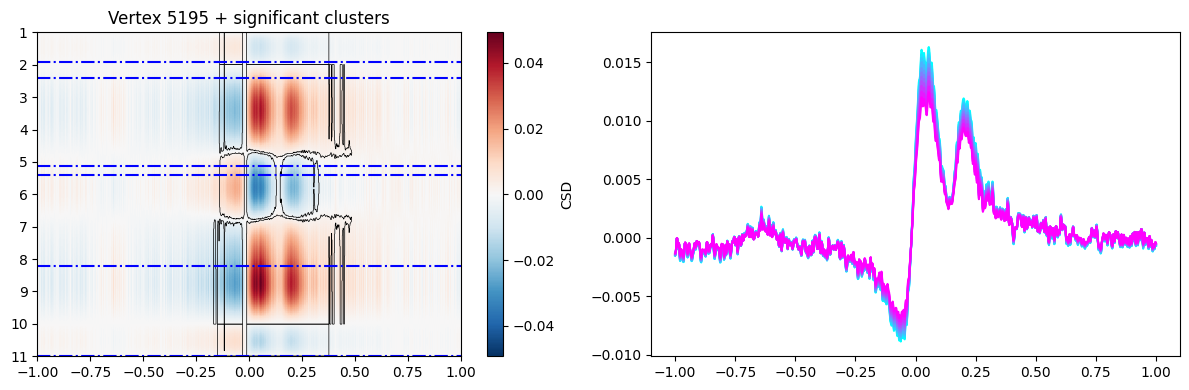

In [82]:
# Plot the mean CSD with significant clusters overlaid
fig, ax = plt.subplots(1,2, figsize=(12,4))

plot_csd(-smooth_csd_emp, time, ax[0], vmin_vmax = None, n_layers=n_layers)
for pos in bb_layer_bound[peak]:
            ax[0].axhline(y=pos, color='b', linestyle='-.')

ax[0].contour(
    pos_significant_mask.T,  
    extent=[time[0], time[-1],  0, 1],
    colors='black',  
    linewidths=0.5,
    levels=[0.5]  # Contour level (binary: only significant areas)
)

ax[0].contour(
    neg_significant_mask.T,  
    extent=[time[0], time[-1],  0, 1],
    colors='black',  
    linewidths=0.5,
    levels=[0.5]  # Contour level (binary: only significant areas)
)

ax[0].set_title(f'Vertex {peak} + significant clusters')

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
#ax[1].plot(time, layer_ts_emp[0], color='lightgray')
for l in range(n_layers):
    ax[1].plot(time, -mean_layer_ts_emp[l,:], label=f'Layer {l}', color=col_r[l, :]) #plot the pial layer ts (could take mean as well)

plt.tight_layout()
plt.savefig('fig_emp_sig.svg')

In [158]:
#np.save("smooth_csd_emp.npy", smooth_csd_emp)
#mask = pos_significant_mask.T | neg_significant_mask.T #mask of the significant values in emp
np.save("significant_mask.npy", mask)

## Comparing emp & simulated
Compare several hypotheses with RMSE

In [31]:
smooth_csd_emp = np.load("smooth_csd_emp.npy")
layer_csds_v1 = np.load("layer_csds_1.npy")
layer_csds_v2 = np.load("layer_csds_2.npy")

In [32]:
mask = np.load("significant_mask.npy")

In [33]:
def normalize_to_minus1_1(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x / (x_max + 0.01)

In [34]:
nlayer_csds_v1 = normalize_to_minus1_1(smooth_csd) #layer_csds_v1[1]
nlayer_csds_v2 = normalize_to_minus1_1(layer_csds_v2[0])
nsmooth_csd_emp = normalize_to_minus1_1(smooth_csd_emp)

In [35]:
# Compute RMSE
rmse_v1 = np.sqrt(np.mean((-nsmooth_csd_emp[mask] - nlayer_csds_v1[mask]) ** 2))
rmse_v2 = np.sqrt(np.mean((-nsmooth_csd_emp[mask] - nlayer_csds_v2[mask]) ** 2))

# Normalize by the standard deviation
std_val = np.std(nsmooth_csd_emp)
nrmse_std_v1 = rmse_v1 / std_val
nrmse_std_v2 = rmse_v2 / std_val
print(f"RMSE between emp & v1 normalized with std: {nrmse_std_v1}")
print(f"RMSE between emp & v2 normalized with std: {nrmse_std_v2}")

RMSE between emp & v1 normalized with std: 1.8402182300874683
RMSE between emp & v2 normalized with std: 1.7770388696856576


In [36]:
rmse_v1

0.31191222187644707

In [37]:
std_val

0.16949740893590726

In [38]:
time = np.linspace(-1000, 1000, 1201)
n_layers = 11
vmin_vmax = [-1, 1]

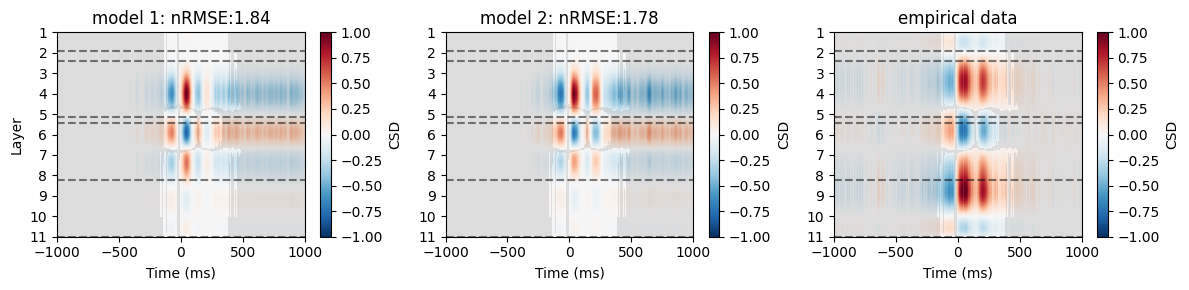

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_csd(nlayer_csds_v1, time, ax[0], n_layers=n_layers, vmin_vmax = vmin_vmax)   
plot_csd(nlayer_csds_v2, time, ax[1], n_layers=n_layers, vmin_vmax = vmin_vmax)  
plot_csd(-nsmooth_csd_emp, time, ax[2], n_layers=n_layers, vmin_vmax = vmin_vmax)
for pos in bb_layer_bound[sim_vertex]:
        ax[0].axhline(y=pos, color='k', linestyle='--', alpha=0.5)
        ax[1].axhline(y=pos, color='k', linestyle='--', alpha=0.5)
        ax[2].axhline(y=pos, color='k', linestyle='--', alpha=0.5)
        
# ax[2].contour(
#     mask,  
#     extent=[time[0], time[-1],  0, 1],
#     colors='black',  
#     linewidths=0.5,
#     levels=[0.5]  # Contour level (binary: only significant areas)
# )

ax[0].set_ylabel('Layer')
ax[0].set_xlabel('Time (ms)')
ax[1].set_xlabel('Time (ms)')
ax[2].set_xlabel('Time (ms)')
ax[0].set_title(f'model 1: nRMSE:{round(nrmse_std_v1,2)}')
ax[1].set_title(f'model 2: nRMSE:{round(nrmse_std_v2,2)}')
ax[2].set_title('empirical data')
plt.tight_layout()

import numpy.ma as ma

# Create an inverted mask: 1 where you want to gray out
inverted_mask = 1 - mask
inverted_mask = np.flipud(inverted_mask)

# Mask the data for alpha transparency
alpha_mask = ma.masked_where(inverted_mask == 0, inverted_mask)

# Overlay with a gray semi-transparent image where mask == 0
for i in range(len(ax)):
    ax[i].imshow(
        alpha_mask,
        cmap='gray',
        interpolation='none',
        extent=[time[0], time[-1], 0, 1],
        aspect='auto',
        alpha=0.1  # adjust transparency (0 = fully transparent, 1 = solid gray)
    )

plt.savefig('fig_03_rmse.svg')